In [7]:
import numpy as np
import pandas as pd

from gensim.models import FastText
from gensim.test.utils import common_texts
from gensim.utils import tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence

# PREPARE DATA TO AUTOENCODER

In [8]:
train = pd.read_csv('../../data/interim/smm4h21/train.csv')
test = pd.read_csv('../../data/interim/smm4h21/test.csv')

In [9]:
sentences = pd.read_csv('../../data/interim/cadec/test.csv')['text'].apply(
                lambda x: x.lower().split('<SENT>')).explode().apply(lambda x: list(tokenize(x))).to_list()

max_seq_len = 10
embed_dim = 300
nb_words = 3000

ftmodel = FastText.load_fasttext_format('../../data/external/embeddings/cc.en.300.bin')
ftmodel.train(sentences=sentences, total_examples=len(sentences), epochs=10)

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [6]:
train[['term', 'STR', 'code']]

,term,STR,code
0,allergies,Drug allergy,10013661
1,HURT YOUR Liver,Liver damage,10024668
2,AD,Attention deficit disorder,10003731
3,focus,Attention impaired,10003738
4,died,Death,10011906
...,...,...,...
1707,orgasm,Inability to orgasm,10021574
1708,never have another orgasm,Inability to orgasm,10021574
1709,coma,Somnolence,10041349
1710,gain so much weight,Wilms tumour,10047986


In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=nb_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False
)

tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

nb_words = min(nb_words, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ftmodel[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        
word_seq_train = tokenizer.texts_to_sequences(train['term'])
word_seq_test = tokenizer.texts_to_sequences(test['term'])

X_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
X_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

labels = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
labels = labels['CODE']
meddra_labels = {v:k for k, v in enumerate(labels.unique())}

y_train = train['code'].apply(lambda x: meddra_labels[x]).to_numpy()
y_test = test['code'].apply(lambda x: meddra_labels[x]).to_numpy()

number_of_classes = labels.unique().shape[0]

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [12]:
embedding_matrix.shape

(3000, 300)

In [10]:
import pickle

with open('../../models/encoder/tokenizer.pickle', 'wb') as tok_bin:
    pickle.dump(tokenizer, tok_bin, pickle.HIGHEST_PROTOCOL)
with open('../../models/encoder/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [11]:
X_train.shape, X_test.shape

((3520, 10), (881, 10))

# MODEL



In [13]:
import keras
from keras import layers, Model
from keras.utils import to_categorical 


vocab_size = nb_words
src_txt_length = max_seq_len
sum_txt_length = max_seq_len

# encoder input model
inputs =   layers.Input(shape=(src_txt_length,))
encoder1 = layers.Embedding(nb_words, embed_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix],trainable=False)(inputs)
encoder2 = layers.Bidirectional(layers.LSTM(256))(encoder1)
encoder3 = layers.Dense(256, activation='relu')(encoder2)
encoder4 = layers.Dense(200, activation='relu')(encoder3)
encoder5 = layers.RepeatVector(sum_txt_length)(encoder4)

# decoder output model
decoder1 = layers.LSTM(256, return_sequences=True)(encoder5)
decoder2 = layers.Dense(256, activation='relu')(decoder1)
outputs =  layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(decoder2)

# tie it together
model = Model(inputs=inputs, outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 300)           900000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               51400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 256)           4679

In [14]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

history = model.fit(
    X_train, 
    to_categorical(X_train, num_classes=nb_words),
    epochs=500,
    validation_data=(X_test, to_categorical(X_test, num_classes=nb_words)),
    callbacks=[earlystopping]
)

Epoch 1/500
110/110 [==============================] - 9s 49ms/step - loss: 3.4394 - val_loss: 1.9827
Epoch 2/500
110/110 [==============================] - 5s 45ms/step - loss: 1.9427 - val_loss: 1.9754
Epoch 3/500
110/110 [==============================] - 5s 43ms/step - loss: 1.9802 - val_loss: 1.9690
Epoch 4/500
110/110 [==============================] - 5s 41ms/step - loss: 1.9430 - val_loss: 1.9610
Epoch 5/500
110/110 [==============================] - 4s 40ms/step - loss: 1.9253 - val_loss: 1.9582
Epoch 6/500
110/110 [==============================] - 4s 39ms/step - loss: 1.9319 - val_loss: 1.9447
Epoch 7/500
110/110 [==============================] - 4s 40ms/step - loss: 1.8901 - val_loss: 1.9315
Epoch 8/500
110/110 [==============================] - 4s 41ms/step - loss: 1.8853 - val_loss: 1.9232
Epoch 9/500
110/110 [==============================] - 4s 40ms/step - loss: 1.8638 - val_loss: 1.9316
Epoch 10/500
110/110 [==============================] - 4s 41ms/step - loss: 1.863

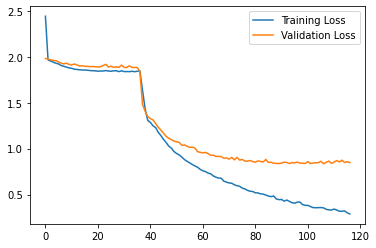

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [30]:
text = ['I felt pain in my left leg']
tokenized = tokenizer.texts_to_sequences(text)
tokenized = sequence.pad_sequences(tokenized, maxlen=max_seq_len)
tokenizer.sequences_to_texts(tokenized), tokenized

(['i felt pain in my left leg'],
 array([[  0,   0,   0,   2, 104,  11,  10,   6, 105,  95]], dtype=int32))

In [31]:
import numpy as np
predicted = [np.argmax(i) for i in model.predict(tokenized)[0]]
tokenizer.sequences_to_texts([predicted])

['had of the of of my legs']

In [32]:
predicted

[0, 0, 0, 20, 8, 4, 8, 8, 6, 69]

# Get encoder

In [41]:
encoder = keras.Sequential(model.layers[:5])
encoder.predict(tokenized).shape

(3, 200)

In [42]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 300)           900000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               51400     
Total params: 2,223,464
Trainable params: 1,323,464
Non-trainable params: 900,000
_________________________________________________________________


In [43]:
encoder.save('../../models/encoder/encoder_cadec.h5')

In [44]:
encoder_loaded = keras.models.load_model('../../models/encoder/encoder_cadec.h5')

In [45]:
encoder_loaded.predict(tokenized).shape

(3, 200)

In [46]:
text = pd.DataFrame([
    'sick of this pain my back yeahh',
    'this is second message',
    'this is third message'
])
text

,0
0,sick of this pain my back yeahh
1,this is second message
2,this is third message


In [47]:

tokenized = tokenizer.texts_to_sequences(text[0])
tokenized = sequence.pad_sequences(tokenized, maxlen=max_seq_len)
#pd.DataFrame()
text['vec'] = tokenizer.texts_to_sequences(text[0])
#text['vec'] = text['vec'].apply(lambda toks: encoder_loaded.predict(toks).shape)
text['vec'] = sequence.pad_sequences(text['vec'], maxlen=max_seq_len).tolist()
text['vec'] = text['vec'].apply(lambda seq: encoder_loaded.predict([seq])[0])
text

,0,vec
0,sick of this pain my back yeahh,"[0.0, 0.0, 2.0932157, 0.0, 0.0, 0.9086473, 0.3..."
1,this is second message,"[0.0, 0.0, 1.5793325, 0.0, 0.0, 0.0, 2.0198689..."
2,this is third message,"[0.0, 0.0, 1.5667237, 0.0, 0.0, 0.0, 2.2308083..."


In [48]:
text['vec'].iloc[0].shape

(200,)